# Bayesian Statistical Inference II

*N. Hernitschek, 2022*

This is the seventh Jupyter notebook for **ASTR 3890 - Selected Topics: Data Science for Large Astronomical Surveys (Spring 2022)**. 
This Jupyter notebook gives an introduction to frequentist statistical inference and maximum likelihood estimation.

It is based on code from the textbook

Statistics, Data Mining and Machine Learning in Astronomy: A Practical Python Guide for the Analysis of
Survey Data - Z. Ivezic, A. J. Connolly, J. T. VanderPlas, A. Gray

as well as on the [MCMC Sampling Tutorial](https://twiecki.io/blog/2015/11/10/mcmc-sampling) by Thomas Wiecki. 

***Exercises required for class participation are in <font color='red'>red</font>.***

---
## Contents
* [Python Packages for MCMC](#first-bullet)
* [MCMC with emcee](#second-bullet)
* [MCMC with pyMC3](#third-bullet)


### Package Installation

***In case you haven't done so already:*** Please pause for a few minutes and install these packages `emcee` and `pymc3` before executing code from today's notebook.

In [ ]:
!pip3 install emcee

In [ ]:
!pip3 install pymc3

In [ ]:
!pip3 install git+https://github.com/dfm/acor@master

## 1. Python Packages for MCMC <a class="anchor" id="first-bullet"></a>

Let's look at some more evolved examples. We will use two popular python modules: `emcee` and `PyMC`. 
Quoting Jake VanderPlas for `emcee` and `PyMC`.
[Jake's blog:](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/)

### emcee

> The emcee package (*also known as MCMC Hammer, which is in the running for best Python package name in history*) is a Pure Python package written by Astronomer Dan Foreman-Mackey. It is a lightweight package which implements a fairly sophisticated Affine-invariant Hamiltonian MCMC. Because the package is pure Python (i.e. it contains no compiled extensions) it is extremely easy to install; with pip, simply type at the command-line "pip install emcee".

Emcee simply requires you to pass it a Python function which returns a value proportional to the log-posterior probability, and returns samples from that posterior.*

### PyMC

> The PyMC package has many more features than emcee, including built-in support for efficient sampling of common prior distributions. PyMC by default uses the classic Metropolis-Hastings sampler, one of the earliest MCMC algorithms. For performance, it uses compiled fortran libraries, so it is less trivial to install using tools like pip. PyMC binaries for many systems can be quite easily installed with conda.*

More details about PyMC are available from [the pyMC User Guide](https://pymc-devs.github.io/pymc/), but note that we are going to be using [PyMC3](https://docs.pymc.io/).


In [3]:
# Execute this cell
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from scipy import integrate
from scipy.stats import norm
from scipy.stats import cauchy
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)
from astroML.plotting.mcmc import convert_to_stdev
import warnings; warnings.simplefilter('ignore')

## 2. MCMC with emcee<a class="anchor" id="first-bullet"></a>


Import `emcee` and generate some homoescedastic Gaussian data. We'll assume the standard deviation is know, so we're only estimating $\mu$.

In [4]:
import emcee

np.random.seed(21)
Ndata = 100
mu = 1.0
sigma = 0.5 # assumed known 
data = stats.norm(mu, sigma).rvs(Ndata)

Define all the relevant functions.

In [5]:
def Likelihood(x, sigma, data):
    # Gaussian likelihood 
    return np.prod(np.exp(-(data-x)**2 /2 /sigma**2))

def Prior(x):
    return 1.0 / 10   # flat: it cancels out and has no effect 

def myPosterior(x, sigma, data):
    return Likelihood(x, sigma, data) * Prior(x)

# emcee wants ln of posterior pdf
def myLogPosterior(x, sigma, data):
    return np.log(myPosterior(x, sigma, data))

`emcee` combines multiple "walkers", each of which is its own MCMC chain. The number of trace results will be nwalkers $\times$ nsteps.

In [6]:
ndim = 1  # number of parameters in the model
nwalkers = 6  # number of MCMC walkers
burn = 1000  # "burn-in" period to let chains stabilize
nsteps = 5000  # number of MCMC steps to take **for each walker**

# initialize theta 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, myLogPosterior, args=[sigma, data])
sampler.run_mcmc(starting_guesses, nsteps)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)

print("done")

done


In [7]:
print(sampler.chain.shape) #original chain structure
print(emcee_trace.shape) #burned and flattened chain

(6, 5000, 1)
(24000, 1)


Text(0.5, 1.0, 'Chain from emcee')

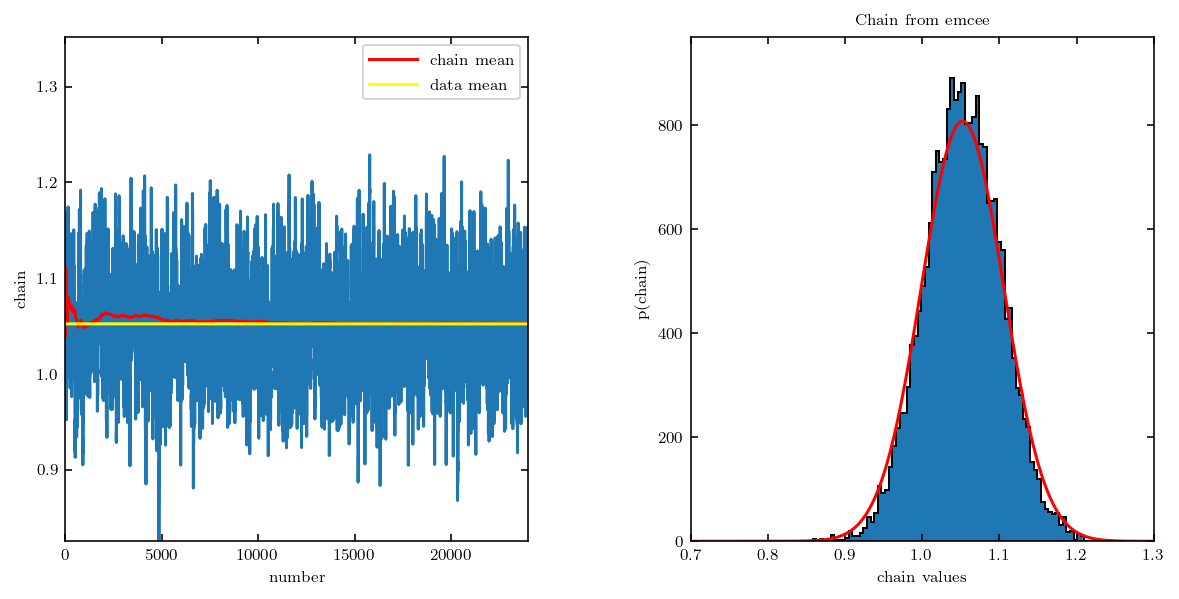

In [9]:
# plot 
fig = plt.figure(figsize=(9, 5))
fig.subplots_adjust(left=0.11, right=0.95, 
                    wspace=0.35, bottom=0.18)

chainE = emcee_trace #[0]
M = np.size(chainE)

ax1 = fig.add_subplot(121)
xgrid = np.linspace(1, M, M)
plt.plot(xgrid, chainE)
ax1.axis([0, M, np.min(chainE), 1.1*np.max(chainE)])
plt.xlabel('number')
plt.ylabel('chain')

# plot running mean: 
meanC = [np.mean(chainE[:int(N)]) for N in xgrid]
ax1.plot(xgrid, meanC, c='red', label='chain mean') 
ax1.plot(xgrid, 0*xgrid + np.mean(data),
         c='yellow',label='data mean')
ax1.legend()

ax2 = fig.add_subplot(122)
# skip first burn samples
Nburn = 1000
Nchain = np.size(chainE[xgrid>burn])
Nhist, bins, patches = plt.hist(chainE[xgrid>Nburn], 
                                bins='auto', histtype='stepfilled')

# plot expectations based on central limit theorem
binwidth = bins[1] - bins[0]
muCLT = np.mean(data)
sigCLT = np.std(data)/np.sqrt(Ndata)
muGrid = np.linspace(0.7, 1.3, 500)
gauss = Nchain * binwidth * stats.norm(muCLT, sigCLT).pdf(muGrid) 
ax2.plot(muGrid, gauss, c='red') 

ax2.set_ylabel('p(chain)')
ax2.set_xlabel('chain values')
ax2.set_xlim(0.7, 1.3)
ax2.set_ylim(0, 1.2*np.max(gauss))
ax2.set_title(r'Chain from emcee')

## 3. MCMC with pyMC3<a class="anchor" id="third-bullet"></a>

Now we will use pyMC3 to get a 2-dimensional posterior pdf for location and scale parameters using a sample drawn from a **Cauchy distribution**. Remember a Cauchy distribution formally has no mean or standard deviation because its tails fall off shallower than $1/x^2$.

The following is code adapted from Figure 5.22 of the textbook. Initially, we load in `PyMC3` and define the Cauchy log likelihood. 

***NOTE:*** The code here for the Cauchy likelihood is actually only for when we look at the analytic estimate, since `PyMC3` has ready-made modules for many standard functions!

In [10]:
from scipy.stats import cauchy
import pymc3 as pm

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

def cauchy_logL(xi, sigma, mu):
    """Equation 5.74: cauchy likelihood"""
    xi = np.asarray(xi)
    n = xi.size
    shape = np.broadcast(sigma, mu).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    return ((n - 1) * np.log(sigma)
            - np.sum(np.log(sigma ** 2 + (xi - mu) ** 2), 0))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Generate some data from the Cauchy distribution.

In [11]:
# ----------------------------------------------------------------------
# Draw the sample from a Cauchy distribution
np.random.seed(44)
mu_0 = 0
gamma_0 = 2
xi = cauchy(mu_0, gamma_0).rvs(10)

Set up the `PyMC3` model.

In [12]:
# ----------------------------------------------------------------------
# Set up and run MCMC:
with pm.Model():
    mu = pm.Uniform('mu', -5, 5) #uniform in Cauchy mu
    log_gamma = pm.Uniform('log_gamma', -10, 10) #uniform in log of Cauchy gamma

    # set up our observed variable x
    # i.e. read this as 'x is distributed as a Cauchy variable'
    x = pm.Cauchy('x', mu, np.exp(log_gamma), observed=xi)

    trace = pm.sample(draws=12000, tune=1000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [log_gamma, mu]


Sampling 2 chains for 1_000 tune and 12_000 draw iterations (2_000 + 24_000 draws total) took 30 seconds.


You may have seen some output messages along the lines of "Auto-assigning NUTS sampler...". `PyMC3` is very sophisticated, and will automatically decide for you the best tools for the job. 

In this case, it decided you needed **No-U-Turn Hamiltonian gradient-based sampling**, where gradient information about the Cauchy likelihood helped in the exploration of parameter space. 

In [14]:
# compute histogram of results to plot below
L_MCMC, mu_bins, gamma_bins = np.histogram2d(trace['mu'],
                                             np.exp(trace['log_gamma']),
                                             bins=(np.linspace(-5, 5, 41),
                                                   np.linspace(0, 5, 41)))
L_MCMC[L_MCMC == 0] = 1E-16  # prevents zero-division errors

# ----------------------------------------------------------------------
# Compute likelihood analytically for comparison
mu = np.linspace(-5, 5, 70)
gamma = np.linspace(0.1, 5, 70)
logL = cauchy_logL(xi, gamma[:, np.newaxis], mu)
logL -= logL.max()

p_mu = np.exp(logL).sum(0)
p_mu /= p_mu.sum() * (mu[1] - mu[0])

p_gamma = np.exp(logL).sum(1)
p_gamma /= p_gamma.sum() * (gamma[1] - gamma[0])

hist_mu, bins_mu = np.histogram(trace['mu'], bins=mu_bins, density=True)
hist_gamma, bins_gamma = np.histogram(np.exp(trace['log_gamma']),
                                      bins=gamma_bins, density=True)

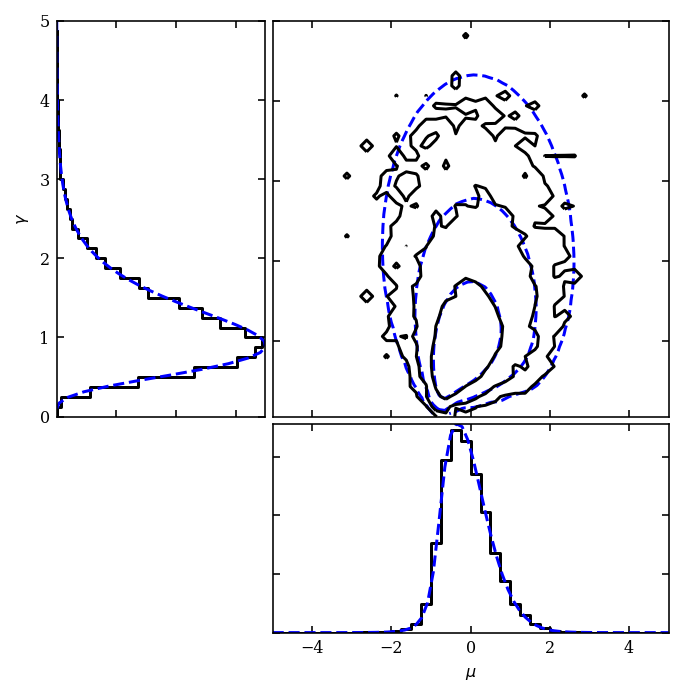

In [15]:
# ----------------------------------------------------------------------
# plot all the results
fig = plt.figure(figsize=(5, 5))

# first axis: likelihood contours
ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.yaxis.set_major_formatter(plt.NullFormatter())

ax1.contour(mu, gamma, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='b', linestyles='dashed')

ax1.contour(0.5 * (mu_bins[:-1] + mu_bins[1:]),
            0.5 * (gamma_bins[:-1] + gamma_bins[1:]),
            convert_to_stdev(np.log(L_MCMC.T)),
            levels=(0.683, 0.955, 0.997),
            colors='k')

# second axis: marginalized over mu
ax2 = fig.add_axes((0.1, 0.4, 0.29, 0.55))
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.plot(hist_gamma, 0.5 * (bins_gamma[1:] + bins_gamma[:-1]
                            - bins_gamma[1] + bins_gamma[0]),
         '-k', drawstyle='steps')
ax2.plot(p_gamma, gamma, '--b')
ax2.set_ylabel(r'$\gamma$')
ax2.set_ylim(0, 5)

# third axis: marginalized over gamma
ax3 = fig.add_axes((0.4, 0.1, 0.55, 0.29))
ax3.yaxis.set_major_formatter(plt.NullFormatter())
ax3.plot(0.5 * (bins_mu[1:] + bins_mu[:-1]), hist_mu,
         '-k', drawstyle='steps-mid')
ax3.plot(mu, p_mu, '--b')
ax3.set_xlabel(r'$\mu$')
plt.xlim(-5, 5)

plt.show()

The resulting 2D joint posterior pdf corner plot shows analytic results as blue dashed lines, and MCMC sampling results as black contours.

<font color='red'>Now create trace plots and interprete them. It will helpful if you take a look at the documentation for both `emcee` and `pymc3` for doing so.</font>
    
- Make traceplots in $\mu$ and $\sigma$, and $\mu$ and $\gamma$, respectively.
- Describe/ discuss where you should cut off burn-in. 
- Compute the autocorrelation length of the chain. 
- Using `corner`, make a corner plot that has labels, shows titles, and has $68\%$ and $95\%$ quantiles and levels. Hint: you can start with this code snipplet:
`import corner
corner.corner(sampler.flatchain, labels=['mu', 'sigma']);`

## Summary <a class="anchor" id="fourth-bullet"></a>

At this point, all of you should have:
* seen two example implementations of MCMC
* seen and understood how and why to make diagnosis plots such as trace plots.